In [62]:
import numpy as np
import pandas as pd
import nltk
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas_profiling
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline
'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')'''

"\nnltk.download('punkt')\nnltk.download('stopwords')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('vader_lexicon')"

In [35]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
valid=pd.read_csv('validation_data.csv')
valid.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Visualization

In [16]:
plt.pie(labels=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], 
        x=[sum(train[i]) for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])

([<matplotlib.patches.Wedge at 0x212ebb2da00>,
 [Text(0.2205229793508023, 1.0776686019265134, 'toxic'),
  Text(-1.0627685713534702, 0.28376568457673707, 'severe_toxic'),
  Text(-0.88354481837012, -0.655246941184247, 'obscene'),
  Text(-0.1465638198299719, -1.0901922063181555, 'threat'),
  Text(0.6339460365091164, -0.8989507343533251, 'insult'),
  Text(1.0913128295372536, -0.1379721279367442, 'identity_hate')])

In [17]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

wordCloud_generator(train['comment_text'], title="Most used words in comments")

KeyboardInterrupt: 

In [ ]:
wordCloud_generator(train[train['score']>0]['comment_text'], title="Most used words in toxic comments")

#train[train['score']>0]['comment_text']

<ipython-input-21-7cd28a862075>:18: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


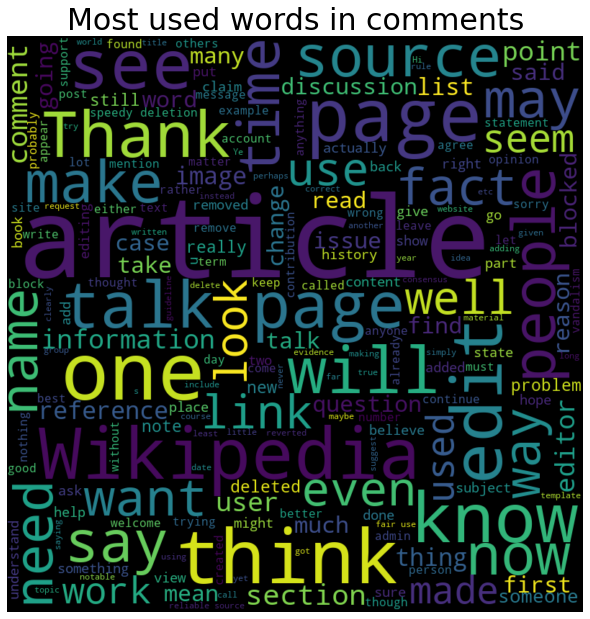

In [23]:
wordCloud_generator(train[train['score']==0]['comment_text'], title="Most used words in common comments")

#train[train['score']>0]['comment_text']

## data preprocess
#### remove some cols
#### score, is upper,
#### remove stop words
#### TFIDF


In [36]:
# calculate the score of comments with 2 decimal
s = {'toxic':0.5, 'severe_toxic':0.7, 'obscene':0.9, 'threat':1.0, 'insult':1.5, 'identity_hate':1.5}
train['score']=0
train['score']=round(train['score']+train['toxic']*s['toxic']+train['severe_toxic']*s['severe_toxic']+train['obscene']*s['obscene']+train['threat']*s['threat']+train['insult']*s['insult']+train['identity_hate']*s['identity_hate'],2)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,score
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0.0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,3.6
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0.0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0.0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0.0


In [37]:
train = train[['comment_text','score']]
train.head()

,comment_text,score
0,Explanation\nWhy the edits made under my usern...,0.0
1,D'aww! He matches this background colour I'm s...,0.0
2,"Hey man, I'm really not trying to edit war. It...",0.0
3,"""\nMore\nI can't make any real suggestions on ...",0.0
4,"You, sir, are my hero. Any chance you remember...",0.0


In [8]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    6. Removes digits
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z]", " ", text) #Remove special Charecters and digits
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text


In [9]:
sid = SentimentIntensityAnalyzer()
def get_pos_sentiment(test):
    sent = sid.polarity_scores(test)
    return sent['pos']
def get_neg_sentiment(test):
    sent = sid.polarity_scores(test)
    return sent['neg']
def get_neu_sentiment(test):
    sent = sid.polarity_scores(test)
    return sent['neu']

In [22]:
replacement_patterns = [(r'won\'t', 'will not'),(r'can\'t', 'cannot'),(r'i\'m', 'i am'),
                        (r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),
                        (r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),
                        (r'(\w+)\'d', '\g<1> would')]

patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]
def replace(text):
    s = text
    for (pattern, repl) in patterns:
        (s, count) = re.subn(pattern, repl, s)
    return s.lower()

In [25]:
# remove stop words
stop_words = set(stopwords.words('english'))
for i in ['`',',','.','!','?','\'','\"','(',')']:
    stop_words.add(i)
def clean_words(x):
    words = []
    for i in x:
        if i.isalnum() and i not in stop_words:
            words.append(i)
    return words

In [32]:
def data_process(dfinp):
    df=dfinp.copy()
    # punctuation mark count
    df['question_mark']=[len(re.findall('\?', m)) for m in df['comment_text']]
    df['exclamation_mark']=[len(re.findall('\!', m)) for m in df['comment_text']]
    # word count, char count
    df['clean_comment'] = df['comment_text'].apply(text_cleaning)
    df['char_count'] = [len(m) for m in df['comment_text']]
    df['upper_letter_count'] = [sum(1 for c in m if c.isupper()) for m in df['comment_text']] # some people may use upper letter when they comment in anger
    # sentiment analysis
    sid = SentimentIntensityAnalyzer()
    df['pos'] = df.clean_comment.apply(get_pos_sentiment)
    df['neg'] = df.clean_comment.apply(get_neg_sentiment)
    df['neu'] = df.clean_comment.apply(get_neu_sentiment)
    # tokenize sentences to words
    replacement_patterns = [(r'won\'t', 'will not'),(r'can\'t', 'cannot'),(r'i\'m', 'i am'),
                            (r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),
                            (r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),
                            (r'(\w+)\'d', '\g<1> would')]

    patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]
    df['clean_comment'] = df['clean_comment'].apply(replace)
    df['words'] = df['clean_comment'].apply(word_tokenize)
    df['word_count'] = [len(w) for w in df['words']]
    # remove stop words
    df['words'] = df['words'].apply(clean_words)

    return df

In [38]:
train=data_process(train)

C:\Users\xurui\Anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: " ." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [38]:
# get the most common words
words_list=[]
for single_words in train[train['score'] == 0]['words']:
    words_list.extend(single_words)
print(collections.Counter(words_list).most_common(20))
words_list=[]
for single_words in train[train['score'] > 0]['words']:
    words_list.extend(single_words)
print(collections.Counter(words_list).most_common(20))

[('article', 55941), ('page', 44027), ('wikipedia', 42447), ('talk', 35693), ('would', 34651), ('please', 28747), ('one', 27462), ('like', 24188), ('see', 20551), ('also', 19796), ('think', 18677), ('edit', 17221), ('know', 16767), ('people', 16383), ('use', 16184), ('articles', 16101), ('may', 15256), ('time', 14657), ('thanks', 13458), ('user', 12742)]
[('fuck', 10000), ('like', 3806), ('shit', 3692), ('wikipedia', 3672), ('fucking', 3337), ('nigger', 3305), ('suck', 3249), ('ass', 3004), ('go', 2962), ('u', 2940), ('hate', 2656), ('get', 2445), ('page', 2376), ('know', 2370), ('gay', 2266), ('die', 2141), ('people', 2068), ('faggot', 2027), ('fat', 1982), ('moron', 1886)]


In [46]:
train['score_flag']=[i if i==0 else 1 for i in train['score'] ]
train

,comment_text,score,question_mark,exclamation_mark,clean_comment,char_count,upper_letter_count,pos,neg,neu,words,word_count,score_flag
0,Explanation\nWhy the edits made under my usern...,0.0,1,0,explanation why the edits made under my userna...,264,17,0.106,0.000,0.894,"[explanation, edits, made, username, hardcore,...",46,0.0
1,D'aww! He matches this background colour I'm s...,0.0,0,1,d aww he matches this background colour i m se...,112,8,0.182,0.126,0.692,"[aww, matches, background, colour, seemingly, ...",16,0.0
2,"Hey man, I'm really not trying to edit war. It...",0.0,0,0,hey man i m really not trying to edit war it s...,233,4,0.069,0.085,0.846,"[hey, man, really, trying, edit, war, guy, con...",44,0.0
3,"""\nMore\nI can't make any real suggestions on ...",0.0,0,0,more i can t make any real suggestions on impr...,622,11,0.083,0.059,0.857,"[make, real, suggestions, improvement, wondere...",116,0.0
4,"You, sir, are my hero. Any chance you remember...",0.0,1,0,you sir are my hero any chance you remember wh...,67,2,0.337,0.000,0.663,"[sir, hero, chance, remember, page]",14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0.0,2,0,and for the second time of asking when your vi...,295,2,0.133,0.102,0.765,"[second, time, asking, view, completely, contr...",46,0.0
159567,You should be ashamed of yourself \n\nThat is ...,0.0,0,0,you should be ashamed of yourself that is a ho...,99,2,0.000,0.320,0.680,"[ashamed, horrible, thing, put, talk, page]",17,0.0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0.0,0,0,spitzer umm theres no actual article for prost...,81,4,0.000,0.180,0.820,"[spitzer, umm, theres, actual, article, prosti...",11,0.0
159569,And it looks like it was actually you who put ...,0.0,0,0,and it looks like it was actually you who put ...,116,2,0.098,0.000,0.902,"[looks, like, actually, put, speedy, first, ve...",25,0.0


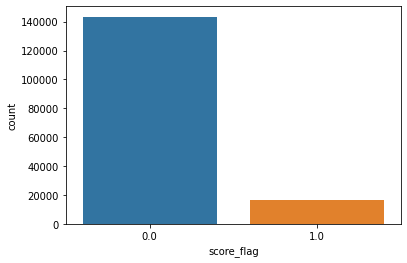

In [63]:
ax=sns.countplot(x = train['score_flag'])
plt.show()

In [40]:
#train.to_csv('train_processed_without_tfidf.csv', index=False)

In [68]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, max_features = 500,stop_words = stop_words)
tfidf.fit(train["clean_comment"])
print(tfidf.get_feature_names())

C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


['able', 'according', 'account', 'actually', 'add', 'added', 'adding', 'address', 'admin', 'administrator', 'admins', 'ago', 'agree', 'already', 'also', 'although', 'always', 'american', 'another', 'answer', 'anti', 'anyone', 'anything', 'anyway', 'appears', 'appreciate', 'appropriate', 'argument', 'around', 'article', 'articles', 'ask', 'asked', 'ass', 'attack', 'attacks', 'away', 'b', 'back', 'background', 'bad', 'banned', 'based', 'believe', 'best', 'better', 'big', 'bit', 'bitch', 'block', 'blocked', 'book', 'books', 'british', 'c', 'call', 'called', 'came', 'care', 'case', 'category', 'certainly', 'change', 'changed', 'changes', 'check', 'city', 'claim', 'claims', 'clear', 'clearly', 'color', 'com', 'come', 'comment', 'comments', 'common', 'community', 'company', 'completely', 'consensus', 'consider', 'considered', 'content', 'continue', 'contribs', 'contributions', 'copyright', 'correct', 'could', 'country', 'course', 'create', 'created', 'criteria', 'current', 'currently', 'date

C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
train_vector = tfidf.transform(list(train.clean_comment))
feature_names = tfidf.get_feature_names()
dense = train_vector.todense()
denselist = dense.tolist()
dftrain = pd.DataFrame(denselist, columns=feature_names)

C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [71]:
cols=['char_count', 'upper_letter_count', 'question_mark', 
      'exclamation_mark', 'word_count', 'pos', 'neg', 'neu']
for col in cols:
    dftrain[col] = train[col]

In [72]:
dftrain=np.nan_to_num(dftrain)

In [79]:
from imblearn.over_sampling import SMOTE

x, y = SMOTE().fit_resample(dftrain, train['score_flag'])
dt_model.fit(x,y)

DecisionTreeClassifier()

In [76]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(np.array(dftrain), np.array([int(i) for i in train['score_flag']]))

DecisionTreeClassifier()

In [77]:
def evaluation(model, preds, test_y):
  print(model, ':')
  sns.heatmap(confusion_matrix(preds,test_y),annot=True,cmap='mako',fmt='d')
  print('Accuracy: ',accuracy_score (preds,test_y))
  print(classification_report(preds, test_y))

Decision Tree
features: top 500 word tf-idf :
Accuracy:  0.9992810791380518
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    142488
         1.0       1.00      1.00      1.00     16083

    accuracy                           1.00    158571
   macro avg       1.00      1.00      1.00    158571
weighted avg       1.00      1.00      1.00    158571



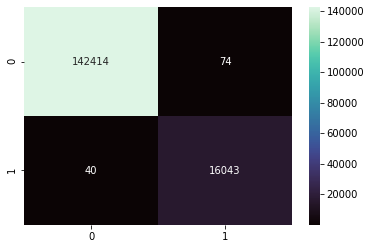

In [81]:
dt_preds = dt_model.predict(np.array(dftrain)[1000:])
evaluation('Decision Tree\nfeatures: top 500 word tf-idf', dt_preds, np.array([int(i) for i in train['score_flag']])[1000:])

In [155]:
valid

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


In [82]:
df1=pd.DataFrame()
df2=pd.DataFrame()
df1['comment_text']=valid['less_toxic']
df1['score']=0
df2['comment_text']=valid['more_toxic']
df2['score']=1
val=pd.concat([df1, df2], ignore_index=True)

In [83]:
val.drop_duplicates(inplace=True)
val

,comment_text,score
0,This article sucks \n\nwoo woo wooooooo,0
1,"""And yes, people should recognize that but the...",0
2,"Western Media?\n\nYup, because every crime in...",0
3,And you removed it! You numbskull! I don't car...,0
4,smelly vagina \n\nBluerasberry why don't you ...,0
...,...,...
60195,Stalking \nI asked you to stop bothering me. ...,1
60196,Hans Adler is a Nazi!!!!! He kept discrimatin...,1
60198,I think you are missing the point. I am 28 and...,1
60204,""" September 2011 (UTC)\nOf course i read it! Y...",1


In [84]:
val=data_process(val)

In [86]:
#val.to_csv('val_processed_without_tfidf.csv', index=False)

In [100]:
#tfidf = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, max_features = 500,stop_words = stop_words)
#tfidf.fit(train["clean_comment"])
val_vec = TfidfVectorizer()
val_vec = TfidfVectorizer(vocabulary=tfidf.vocabulary_)
val_vec.fit_transform(val['clean_comment'])

<23210x500 sparse matrix of type '<class 'numpy.float64'>'
	with 268548 stored elements in Compressed Sparse Row format>

In [107]:
df = val_vec.transform(list(val.clean_comment))
feature_names = val_vec.get_feature_names()
dense = df.todense()
denselist = dense.tolist()
df_new = pd.DataFrame(denselist, columns=feature_names)

C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [109]:
cols=['char_count', 'upper_letter_count', 'question_mark', 'exclamation_mark',
       'word_count', 'pos', 'neg', 'neu']
for col in cols:
    df_new[col] = val[col]


In [110]:
df_new

,able,according,account,actually,add,added,adding,address,admin,administrator,...,yes,yet,char_count,upper_letter_count,question_mark,exclamation_mark,word_count,pos,neg,neu
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,38.0,1.0,0.0,0.0,6.0,0.530,0.214,0.256
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.327693,0.0,233.0,4.0,0.0,0.0,40.0,0.263,0.140,0.596
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,97.0,4.0,1.0,0.0,16.0,0.000,0.333,0.667
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,134.0,4.0,0.0,4.0,27.0,0.104,0.212,0.684
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,134.0,2.0,0.0,0.0,23.0,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23205,0.0,0.000000,0.0,0.0,0.275429,0.0,0.0,0.0,0.262272,0.0,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23206,0.0,0.158137,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.130281,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23207,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23208,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.222185,0.0,296.0,5.0,1.0,0.0,52.0,0.114,0.106,0.780


In [ ]:
df_new=np.nan_to_num(df_new)

Decision Tree
features: top 500 word tf-idf :
Accuracy:  0.5207238259370961
              precision    recall  f1-score   support

         0.0       0.73      0.51      0.60     16530
         1.0       0.31      0.54      0.39      6680

    accuracy                           0.52     23210
   macro avg       0.52      0.53      0.50     23210
weighted avg       0.61      0.52      0.54     23210



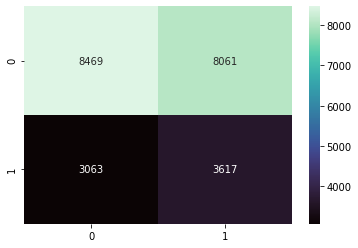

In [103]:
dt_preds = dt_model.predict(df_new)
evaluation('Decision Tree\nfeatures: top 500 word tf-idf', dt_preds, val['score'])

Next Step:
change the toxic score of train data -- it is not good for the valid data
model
more vector